In [684]:
import pandas as pd
import numpy as np
import imblearn.over_sampling as imb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

## Wczytanie danych

In [594]:
df = pd.read_csv('input/KaggleV2-May-2016.csv')

## Podstawowe informacje o danych

In [595]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [255]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [256]:
df[['Age','Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received']].describe()

,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [654]:
df['No-show'].value_counts(normalize=True)

No     0.798067
Yes    0.201933
Name: No-show, dtype: float64

In [258]:
df['Gender'].value_counts(normalize=True)

F    0.649977
M    0.350023
Name: Gender, dtype: float64

## Przygotnowanie danych 


In [612]:
df['ScheduledDay_dt'] = pd.to_datetime(df['ScheduledDay'])

In [613]:
df['AppointmentDay_dt'] = pd.to_datetime(df['AppointmentDay'])

In [614]:
df['SHour'] = df['ScheduledDay_dt'].dt.hour
df['SMinute'] = df['ScheduledDay_dt'].dt.minute
df['SSecond'] = df['ScheduledDay_dt'].dt.second

In [615]:
df['Gender_maped'] = df['Gender'].map({'M':0, 'F':1})

appointment_day_dict = {name:i for i, name in enumerate(df['AppointmentDay'].unique())}
df['AppD'] = df['AppointmentDay'].map(appointment_day_dict)

Neighb_dict = {name:i for i, name in enumerate(df['Neighbourhood'].unique())}
df['Neigh'] = df['Neighbourhood'].map(Neighb_dict)

In [616]:
features = ['Gender_maped','Age', 'AppD', 'Neigh', 'Scholarship',
            'Hipertension', 'Diabetes', 'Alcoholism','Handcap',
            'SMS_received', 'SHour', 'SMinute', 'SSecond']

## Prosty model

In [637]:
X = df[features]
y = df['No-show'].map({'No': 0, 'Yes': 1})

In [681]:
tree = DecisionTreeClassifier(max_depth=7)
cv = cross_val_score(tree, X, y,cv=10, scoring='f1')

In [682]:
cv.mean(), cv.std()

(0.004345342415064771, 0.00190388743763885)

# Oversampling

In [685]:
def resample_data(method, X, y, estimator=DecisionTreeClassifier(max_depth=7), metric='f1'):
    X_set = X.copy()
    y_set = y.copy()
    X_res, y_res = method.fit_resample(X_set, y_set)
    df = pd.DataFrame(X_res, columns=features)
    
    ratios =[]
    for feat in features:
        if len(df[feat].unique()) <=3:
            print(feat)
            print(df[feat].value_counts(normalize=True))
            ratios.append(df[feat].value_counts(normalize=True).values)
    cv = cross_val_score(estimator, X_res, y_res, cv=10, scoring=metric)
    
    print('....................')
    print('Sredni f1 po cv: {}'.format(cv.mean()))
    print('Std f1 po cv: {}'.format(cv.std()))
    return ratios, cv

## Random oversampling

In [674]:
RAND_r, RAND_cv = resample_data(imb.RandomOverSampler(random_state=42), X, y)

Gender_maped
1    0.65129
0    0.34871
Name: Gender_maped, dtype: float64
Scholarship
0    0.89552
1    0.10448
Name: Scholarship, dtype: float64
Hipertension
0    0.813815
1    0.186185
Name: Hipertension, dtype: float64
Diabetes
0    0.931106
1    0.068894
Name: Diabetes, dtype: float64
Alcoholism
0    0.969425
1    0.030575
Name: Alcoholism, dtype: float64
SMS_received
0    0.635968
1    0.364032
Name: SMS_received, dtype: float64
....................
Sredni f1 po cv: 0.5743053057990612
Std f1 po cv: 0.03110137927815009


## SMOTE

### Zwykły SMOTE

In [575]:
SMOTE_r, SMOTE_cv = resample_data(imb.SMOTE(random_state=42), X, y)

Gender_maped
1    0.573485
0    0.426515
Name: Gender_maped, dtype: float64
Scholarship
0    0.930953
1    0.069047
Name: Scholarship, dtype: float64
Hipertension
0    0.846567
1    0.153433
Name: Hipertension, dtype: float64
Diabetes
0    0.950056
1    0.049944
Name: Diabetes, dtype: float64
Alcoholism
0    0.980172
1    0.019828
Name: Alcoholism, dtype: float64
SMS_received
0    0.719436
1    0.280564
Name: SMS_received, dtype: float64
....................
Sredni f1 po cv: 0.6141770333132482
Std f1 po cv: 0.07939338979539619


### SVMSMOTE

In [411]:
resample_data(imb.SVMSMOTE(random_state=42), X, y)

Gender_maped
1    0.61304
0    0.38696
Name: Gender_maped, dtype: float64
Scholarship
0    0.906148
1    0.093852
Name: Scholarship, dtype: float64
Hipertension
0    0.829125
1    0.170875
Name: Hipertension, dtype: float64
Diabetes
0    0.93983
1    0.06017
Name: Diabetes, dtype: float64
Alcoholism
0    0.973772
1    0.026228
Name: Alcoholism, dtype: float64
SMS_received
0    0.686157
1    0.313843
Name: SMS_received, dtype: float64
....................
Sredni f1 po cv: 0.5760532342796613
Std f1 po cv: 0.10790443948415585


### BORDERLINESMOTE

In [678]:
SMOTEB_r, SMOTEB_cv = resample_data(imb.BorderlineSMOTE(random_state=42), X, y )

Gender_maped
1    0.573791
0    0.426209
Name: Gender_maped, dtype: float64
Scholarship
0    0.930772
1    0.069228
Name: Scholarship, dtype: float64
Hipertension
0    0.849027
1    0.150973
Name: Hipertension, dtype: float64
Diabetes
0    0.950441
1    0.049559
Name: Diabetes, dtype: float64
Alcoholism
0    0.980127
1    0.019873
Name: Alcoholism, dtype: float64
SMS_received
0    0.719623
1    0.280377
Name: SMS_received, dtype: float64
....................
Sredni f1 po cv: 0.6228002764746743
Std f1 po cv: 0.07937549774024352


## ADASYN

In [578]:
ADASYN_r, ADASYN_cv = resample_data(imb.ADASYN(random_state=42), X, y)

Gender_maped
1    0.57326
0    0.42674
Name: Gender_maped, dtype: float64
Scholarship
0    0.93132
1    0.06868
Name: Scholarship, dtype: float64
Hipertension
0    0.845724
1    0.154276
Name: Hipertension, dtype: float64
Diabetes
0    0.950141
1    0.049859
Name: Diabetes, dtype: float64
Alcoholism
0    0.980124
1    0.019876
Name: Alcoholism, dtype: float64
SMS_received
0    0.719759
1    0.280241
Name: SMS_received, dtype: float64
....................
Sredni f1 po cv: 0.6054581029085302
Std f1 po cv: 0.11812672016053938


## Porownanie graficzne

In [686]:
base = [df['Gender_maped'].value_counts(normalize=True).values,
        df['Scholarship'].value_counts(normalize=True).values,
        df['Hipertension'].value_counts(normalize=True).values,
        df['Diabetes'].value_counts(normalize=True).values,
        df['Alcoholism'].value_counts(normalize=True).values,
        df['SMS_received'].value_counts(normalize=True).values,
       ]

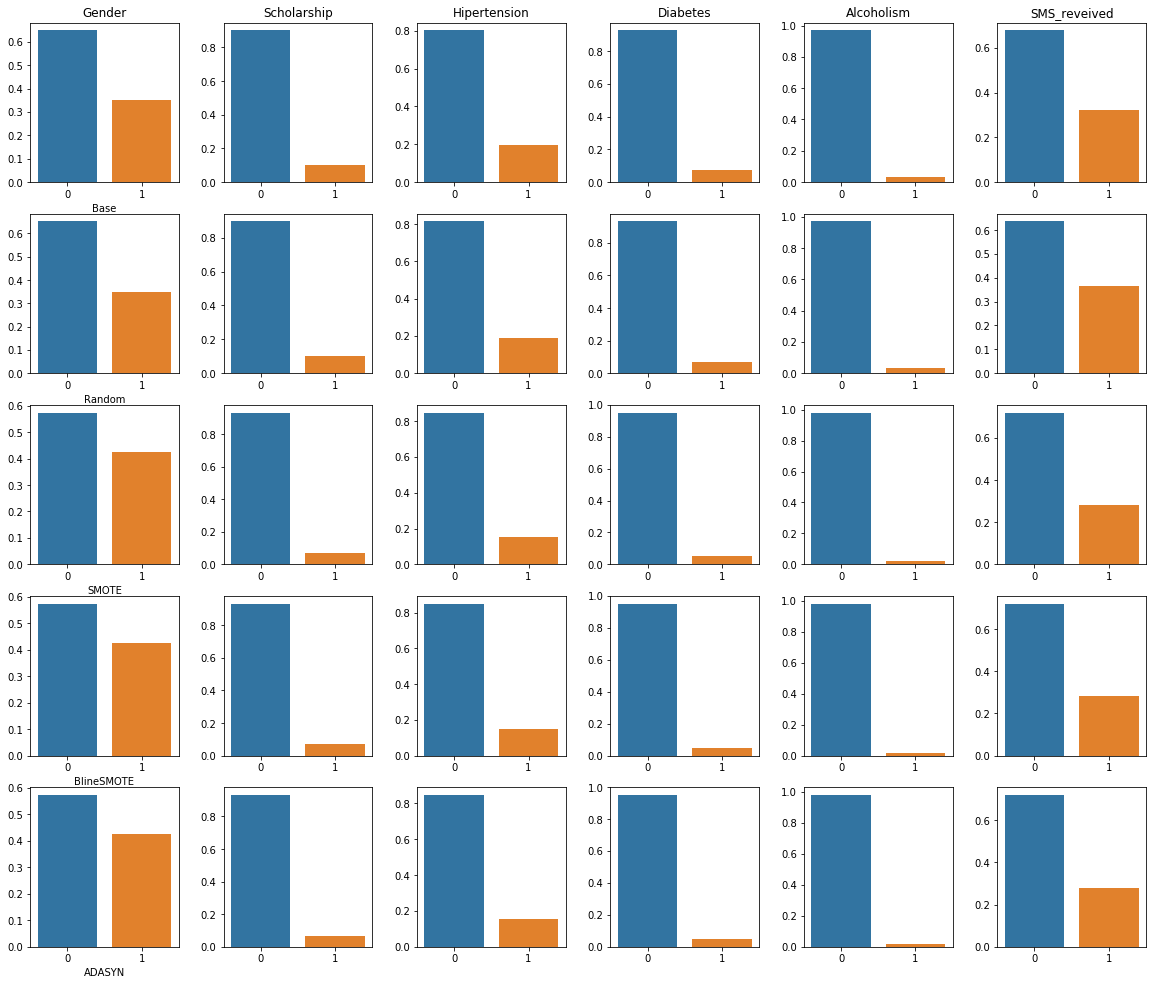

In [583]:
fig, ax = plt.subplots(5, 6, figsize=(20,17), )
methods = [base, RAND_r, SMOTE_r, SMOTEB_r, ADASYN_r]

for i, method in enumerate(methods):
    for j, score, in enumerate(method):
        sns.barplot([0,1], score, ax=ax[i, j])
        
ax[0,0].set_title('Gender')
ax[0,1].set_title('Scholarship')
ax[0,2].set_title('Hipertension')
ax[0,3].set_title('Diabetes')
ax[0,4].set_title('Alcoholism')
ax[0,5].set_title('SMS_reveived')
ax[0,0].set_xlabel('Base')
ax[1,0].set_xlabel('Random')
ax[2,0].set_xlabel('SMOTE')
ax[3,0].set_xlabel('BlineSMOTE')
ax[4,0].set_xlabel('ADASYN')


plt.subplots_adjust(wspace=0.3)        
plt.show()        

## Rozne proporcje wilekości wygenerowanych danych  

In [688]:
SMOTEB_r_09, SMOTEB_cv_09 = resample_data(imb.BorderlineSMOTE(sampling_strategy=0.9,random_state=42), X, y)

Gender_maped
1    0.580471
0    0.419529
Name: Gender_maped, dtype: float64
Scholarship
0    0.928435
1    0.071565
Name: Scholarship, dtype: float64
Hipertension
0    0.845115
1    0.154885
Name: Hipertension, dtype: float64
Diabetes
0    0.948519
1    0.051481
Name: Diabetes, dtype: float64
Alcoholism
0    0.9792
1    0.0208
Name: Alcoholism, dtype: float64
SMS_received
0    0.71594
1    0.28406
Name: SMS_received, dtype: float64
....................
Sredni f1 po cv: 0.5539684642503452
Std f1 po cv: 0.1088495782982089


In [585]:
SMOTEB_r065, SMOTEB_cv_065 = resample_data(imb.BorderlineSMOTE(sampling_strategy=0.65,random_state=42), X, y)

Gender_maped
1    0.600544
0    0.399456
Name: Gender_maped, dtype: float64
Scholarship
0    0.920697
1    0.079303
Name: Scholarship, dtype: float64
Hipertension
0    0.832572
1    0.167428
Name: Hipertension, dtype: float64
Diabetes
0    0.942732
1    0.057268
Name: Diabetes, dtype: float64
Alcoholism
0    0.976399
1    0.023601
Name: Alcoholism, dtype: float64
SMS_received
0    0.704816
1    0.295184
Name: SMS_received, dtype: float64
....................
Sredni f1 po cv: 0.356244348829833
Std f1 po cv: 0.11765217204349668


# Linki

https://imbalanced-learn.readthedocs.io/en/stable/index.html

https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/